In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
import cv2
import os
import numpy as np

In [ ]:
dataset_path= '/content/drive/MyDrive/Jyothi Surekha/top_15_species'

In [ ]:
def load_and_preprocess_images(dataset_path, image_size=(128, 128)):
    images = []
    labels = []

    # Iterate through class directories
    for class_dir in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_dir)
        class_label = int(class_dir)  # Convert directory name to label if needed

        # Iterate through images in the class directory
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)

            # Read and preprocess the image
            image = cv2.imread(image_path)
            image = cv2.resize(image, image_size)
            image = image.astype(np.float32) / 255.0  # Normalize pixel values

            # Append the image and label to lists
            images.append(image)
            labels.append(class_label)

    return np.array(images), np.array(labels)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Constants
IMAGE_RES = 224
BATCH_SIZE = 32
# Load the dataset
data = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(IMAGE_RES, IMAGE_RES),
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # 20% of the data will be used for testing
    subset="training",     # Specify "training" to get the training subset
    seed=42,
    label_mode='int'
)
num_examples = data.cardinality().numpy()
num_classes = len(data.class_names)

# Split the data into training and testing
testing_data = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(IMAGE_RES, IMAGE_RES),
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # No validation split for testing
    seed=42,
    label_mode='int',
    subset="validation"    # Specify "validation" to get the testing subset
)

Found 1568 files belonging to 15 classes.
Using 1255 files for training.
Found 1568 files belonging to 15 classes.
Using 313 files for validation.


In [ ]:
for images, labels in data.take(1):  # Take one batch from the dataset
    print(labels)

tf.Tensor(
[ 6  3  3 12  5 12 11  1  5  0  3  3 13  9  5  0  2  2  7  0  7  6  5 14
  2  2  5 13  3  7 12  6], shape=(32,), dtype=int32)


In [ ]:
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
    return image, label
train_data = data
# Define the validation split ratio
validation_split = 0.2
num_validation_samples = int(num_examples * validation_split)
validation_data = data.take(num_validation_samples)

train_batches = train_data.map(format_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_batches = validation_data.map(format_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)


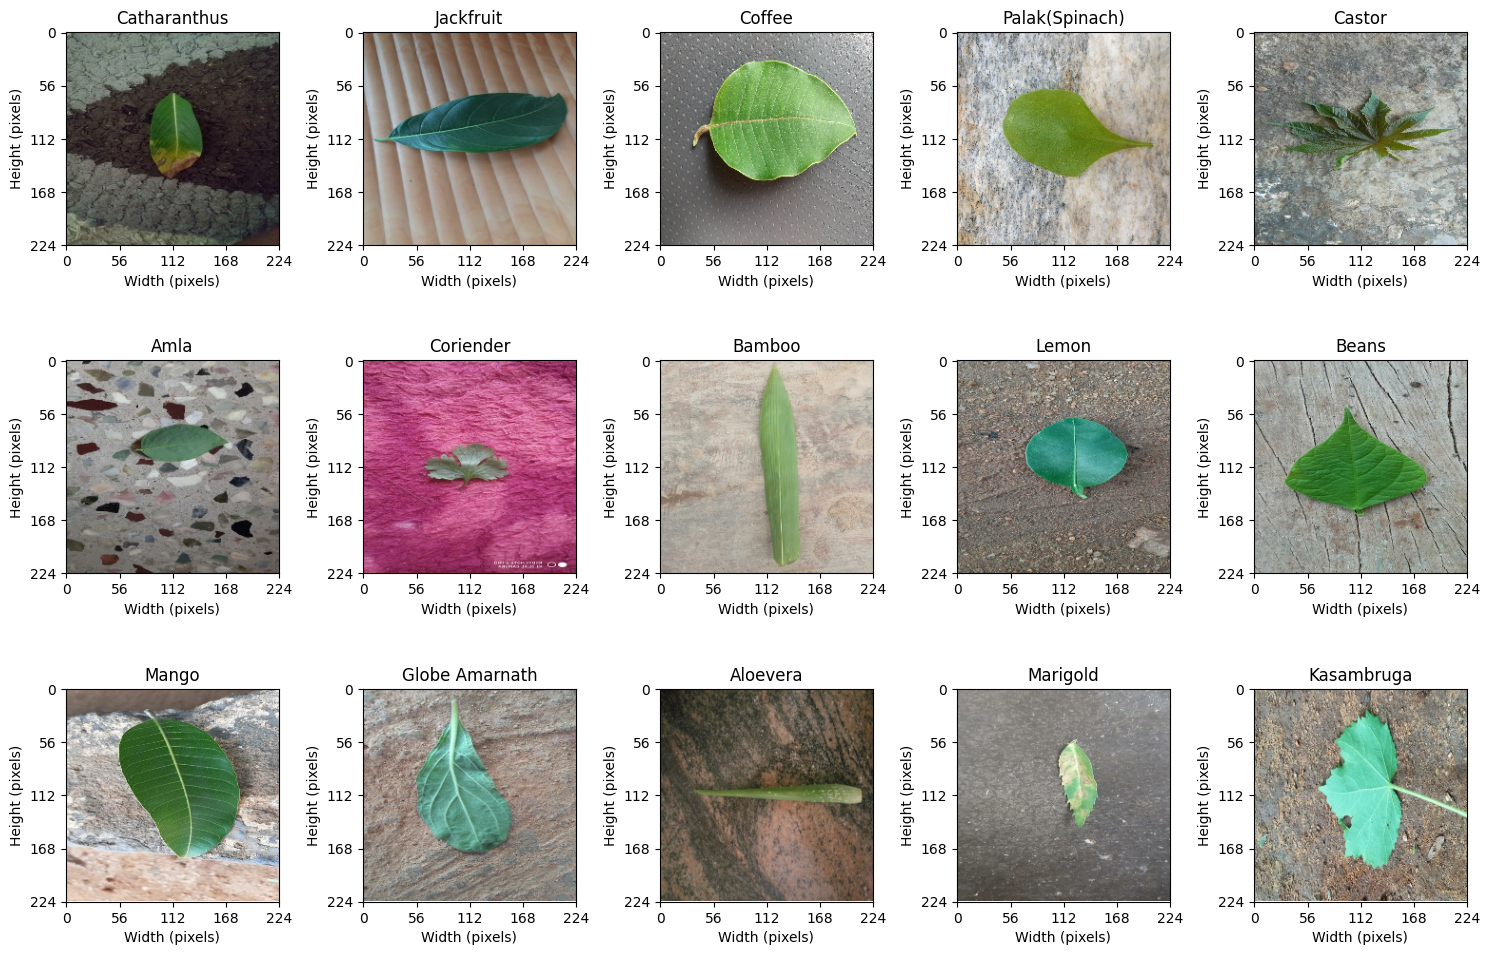

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 10))

# Dictionary to store one image per species
class_images = {}
class_labels = {}

# Iterate through batches until all 15 species are found
for images, labels in train_batches:
    images = images.numpy()  # Convert tensors to NumPy
    labels = labels.numpy()

    for i in range(len(labels)):
        class_name = data.class_names[labels[i]]

        # Store only one image per class
        if class_name not in class_images:
            # Corrected the transpose to move color channel to last dimension
            class_images[class_name] = np.transpose(images[i] * 255, (1, 0, 2)).astype("uint8")
            class_labels[class_name] = labels[i]

        # Stop when we have all 15 species
        if len(class_images) == 15:
            break
    if len(class_images) == 15:
        break

# Plot the images with scale labels
for i, (class_name, img) in enumerate(class_images.items()):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("on")  # Turn on the axis

    # Label x and y axis
    ax.set_xlabel("Width (pixels)")
    ax.set_ylabel("Height (pixels)")

    # Set ticks at intervals (optional: adjust spacing)
    h, w, _ = img.shape
    ax.set_xticks(np.linspace(0, w, num=5))  # 5 tick marks along width
    ax.set_yticks(np.linspace(0, h, num=5))  # 5 tick marks along height

    # Format tick labels (optional)
    ax.set_xticklabels([f"{int(x)}" for x in np.linspace(0, w, num=5)])
    ax.set_yticklabels([f"{int(y)}" for y in np.linspace(0, h, num=5)])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [ ]:
base_model = tf.keras.applications.InceptionV3(
    input_shape=(IMAGE_RES, IMAGE_RES, 3),
    include_top=False,
    weights='imagenet'
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

# Create the final model
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(train_batches, validation_data=validation_batches, epochs=10)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 263s 6s/step - accuracy: 0.3306 - loss: 2.2091 - val_accuracy: 0.8359 - val_loss: 0.7310
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 196s 5s/step - accuracy: 0.8268 - loss: 0.7019 - val_accuracy: 0.9492 - val_loss: 0.3892
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 205s 5s/step - accuracy: 0.9171 - loss: 0.4272 - val_accuracy: 0.9688 - val_loss: 0.2728
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 193s 5s/step - accuracy: 0.9456 - loss: 0.3012 - val_accuracy: 0.9766 - val_loss: 0.2076
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 180s 5s/step - accuracy: 0.9665 - loss: 0.2286 - val_accuracy: 0.9922 - val_loss: 0.1661
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 207s 5s/step - accuracy: 0.9810 - loss: 0.1813 - val_accuracy: 0.9922 - val_loss: 0.1379
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 190s 4s/step - accuracy: 0.9858 - loss: 0.1484 - val_accuracy: 0.9961 - val_loss: 0.1171
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 175s 4s/step - accuracy: 0.9943 - loss: 0.1242 - val_accuracy: 0.9961 - v

In [ ]:
testing_batches = testing_data.map(format_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_loss, test_accuracy = model.evaluate(testing_batches)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

10/10 ━━━━━━━━━━━━━━━━━━━━ 64s 6s/step - accuracy: 0.8828 - loss: 0.3450
Test Accuracy: 0.884984016418457
Test Loss: 0.34543555974960327


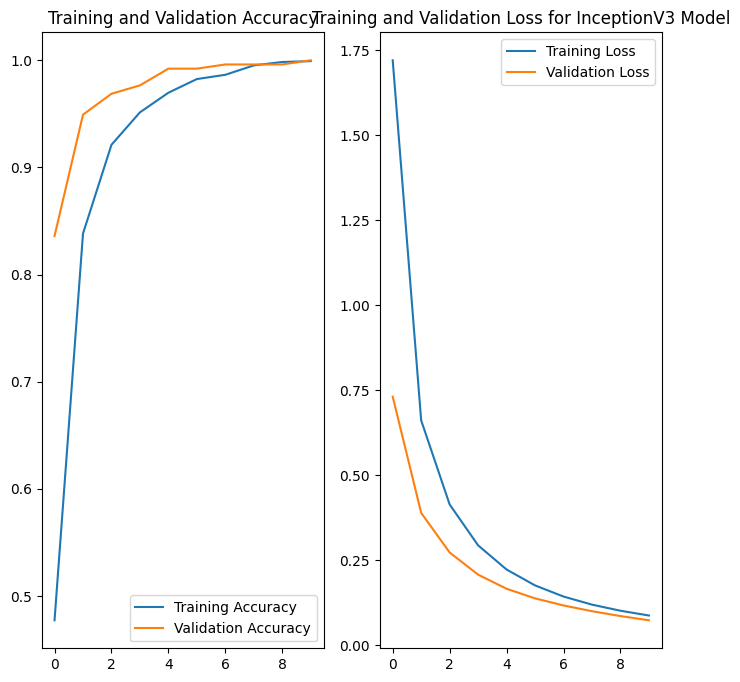

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# The number of epochs was set to 10 in model.fit
EPOCHS = 10  # Define EPOCHS here
epochs_range = range(EPOCHS) # This line was repeated unnecessarily


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for InceptionV3 Model')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step


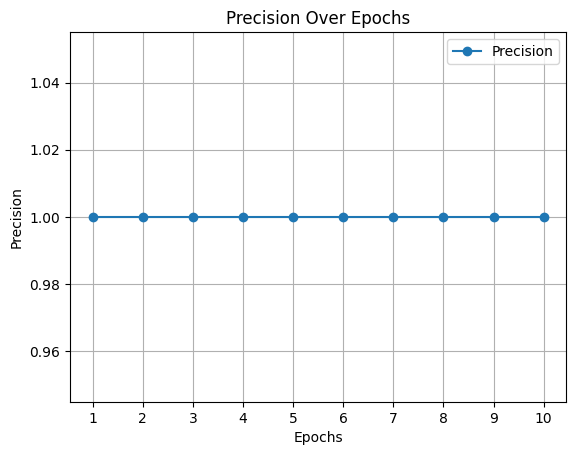

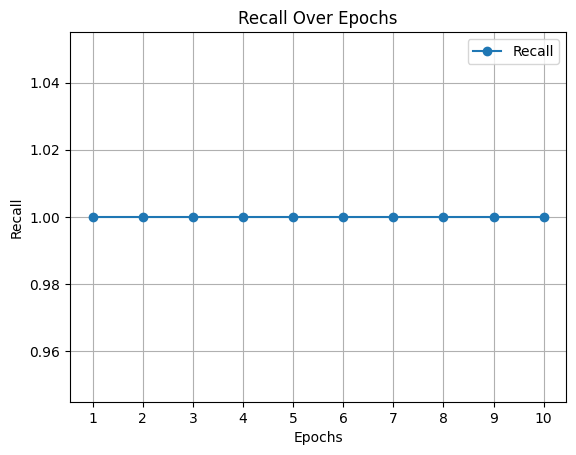

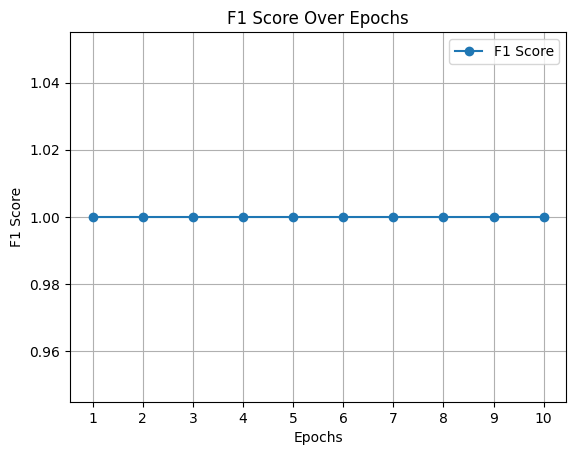

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

def plot_metric_over_epochs(metric_history, metric_name):
    plt.plot(range(1, len(metric_history) + 1), metric_history, marker='o', label=metric_name)
    plt.title(f'{metric_name} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.xticks(range(1, len(metric_history) + 1))
    plt.grid(True)
    plt.legend()
    plt.show()

# Assuming you have your model and validation_batches defined
# Get predictions on the validation data
y_pred_probs = model.predict(validation_batches)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels from validation_batches
y_true = np.concatenate([y for x, y in validation_batches], axis=0)

# Calculate precision, recall, and F1 score for each epoch
precision_history = []
recall_history = []
f1_history = []

for i in range(10):  # Replace 10 with the number of epochs you trained for
    # Calculate metrics for this epoch
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    precision_history.append(precision)
    recall_history.append(recall)
    f1_history.append(f1)

# Plot precision, recall, and F1 score
plot_metric_over_epochs(precision_history, 'Precision')
plot_metric_over_epochs(recall_history, 'Recall')
plot_metric_over_epochs(f1_history, 'F1 Score')

Found 1568 images belonging to 15 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 227s 5s/step


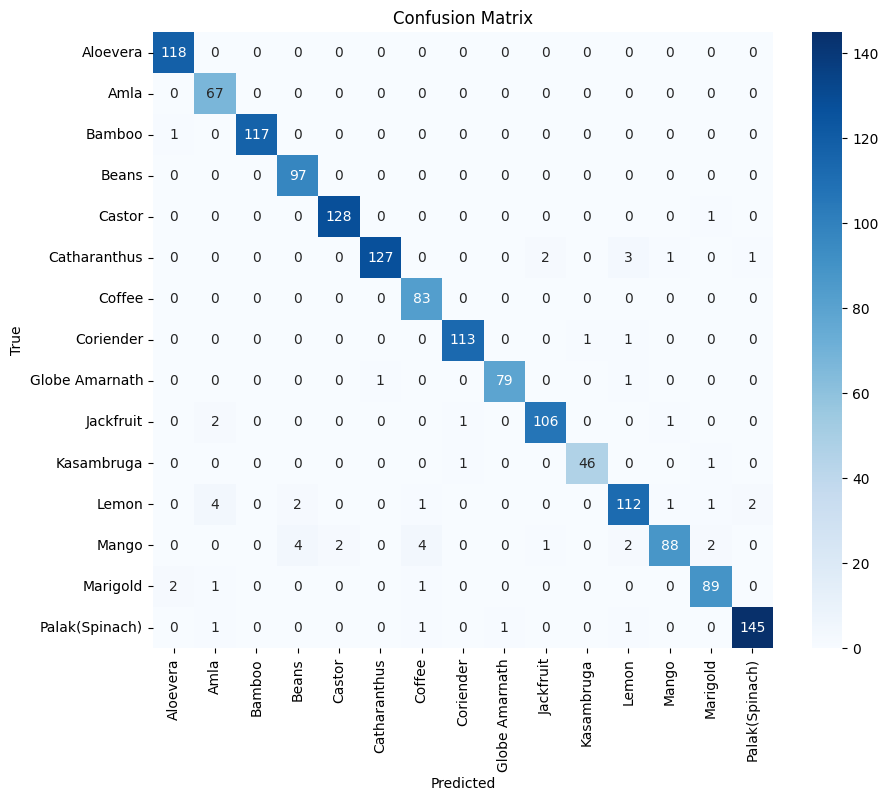

Classification Report:

                precision    recall  f1-score   support

      Aloevera       0.98      1.00      0.99       118
          Amla       0.89      1.00      0.94        67
        Bamboo       1.00      0.99      1.00       118
         Beans       0.94      1.00      0.97        97
        Castor       0.98      0.99      0.99       129
  Catharanthus       0.99      0.95      0.97       134
        Coffee       0.92      1.00      0.96        83
     Coriender       0.98      0.98      0.98       115
Globe Amarnath       0.99      0.98      0.98        81
     Jackfruit       0.97      0.96      0.97       110
    Kasambruga       0.98      0.96      0.97        48
         Lemon       0.93      0.91      0.92       123
         Mango       0.97      0.85      0.91       103
      Marigold       0.95      0.96      0.95        93
Palak(Spinach)       0.98      0.97      0.98       149

      accuracy                           0.97      1568
     macro avg       0

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator

def plot_confusion_matrix(model, generator):
    # Predict the classes
    Y_pred = model.predict(generator)
    y_pred = np.argmax(Y_pred, axis=1)

    # True labels
    true_labels = generator.classes

    # Get class names
    class_names = list(generator.class_indices.keys())

    # Create the confusion matrix
    cm = confusion_matrix(true_labels, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print("Classification Report:\n")
    print(classification_report(true_labels, y_pred, target_names=class_names))

# Create the validation generator
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    dataset_path,
    target_size=(IMAGE_RES, IMAGE_RES),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
)

# Call the function with your model and validation generator
plot_confusion_matrix(model, validation_generator)

In [ ]:
import tensorflow as tf
# Suppress TensorFlow warnings
tf.get_logger().setLevel("ERROR")
# Save the trained model to a file
model.save("/content/drive/MyDrive/Models/Model_InceptionV3.h5")
# Download the saved model file
from google.colab import files
files.download("Model_InceptionV3.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


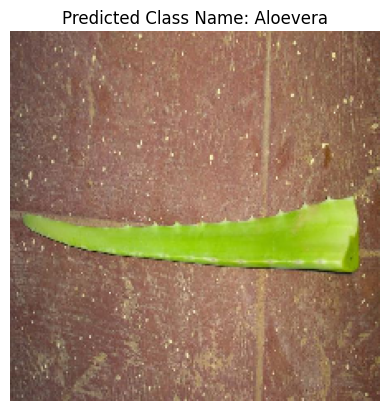

In [ ]:
input_image_path = '/content/drive/MyDrive/Plant Images/alovera.jpg'
input_image = load_img(input_image_path, target_size=(IMAGE_RES, IMAGE_RES))
input_image_array = img_to_array(input_image)
input_image_array = input_image_array / 255.0  # Normalize the image
input_image_array = input_image_array[tf.newaxis, ...]
predictions = model.predict(input_image_array)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
predicted_class_name = data.class_names[predicted_class_index]
plt.imshow(input_image)
plt.title("Predicted Class Name: " + predicted_class_name)
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


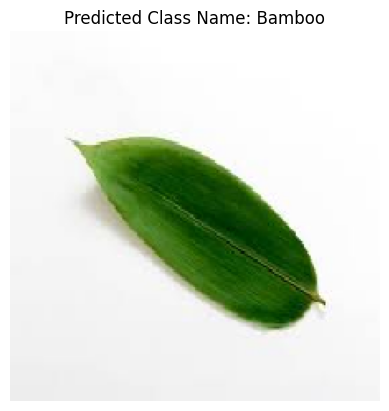

In [ ]:
input_image_path = '/content/drive/MyDrive/Plant Images/Bamboo.jpeg'
input_image = load_img(input_image_path, target_size=(IMAGE_RES, IMAGE_RES))
input_image_array = img_to_array(input_image)
input_image_array = input_image_array / 255.0  # Normalize the image
input_image_array = input_image_array[tf.newaxis, ...]
predictions = model.predict(input_image_array)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
predicted_class_name = data.class_names[predicted_class_index]
plt.imshow(input_image)
plt.title("Predicted Class Name: " + predicted_class_name)
plt.axis("off")
plt.show()

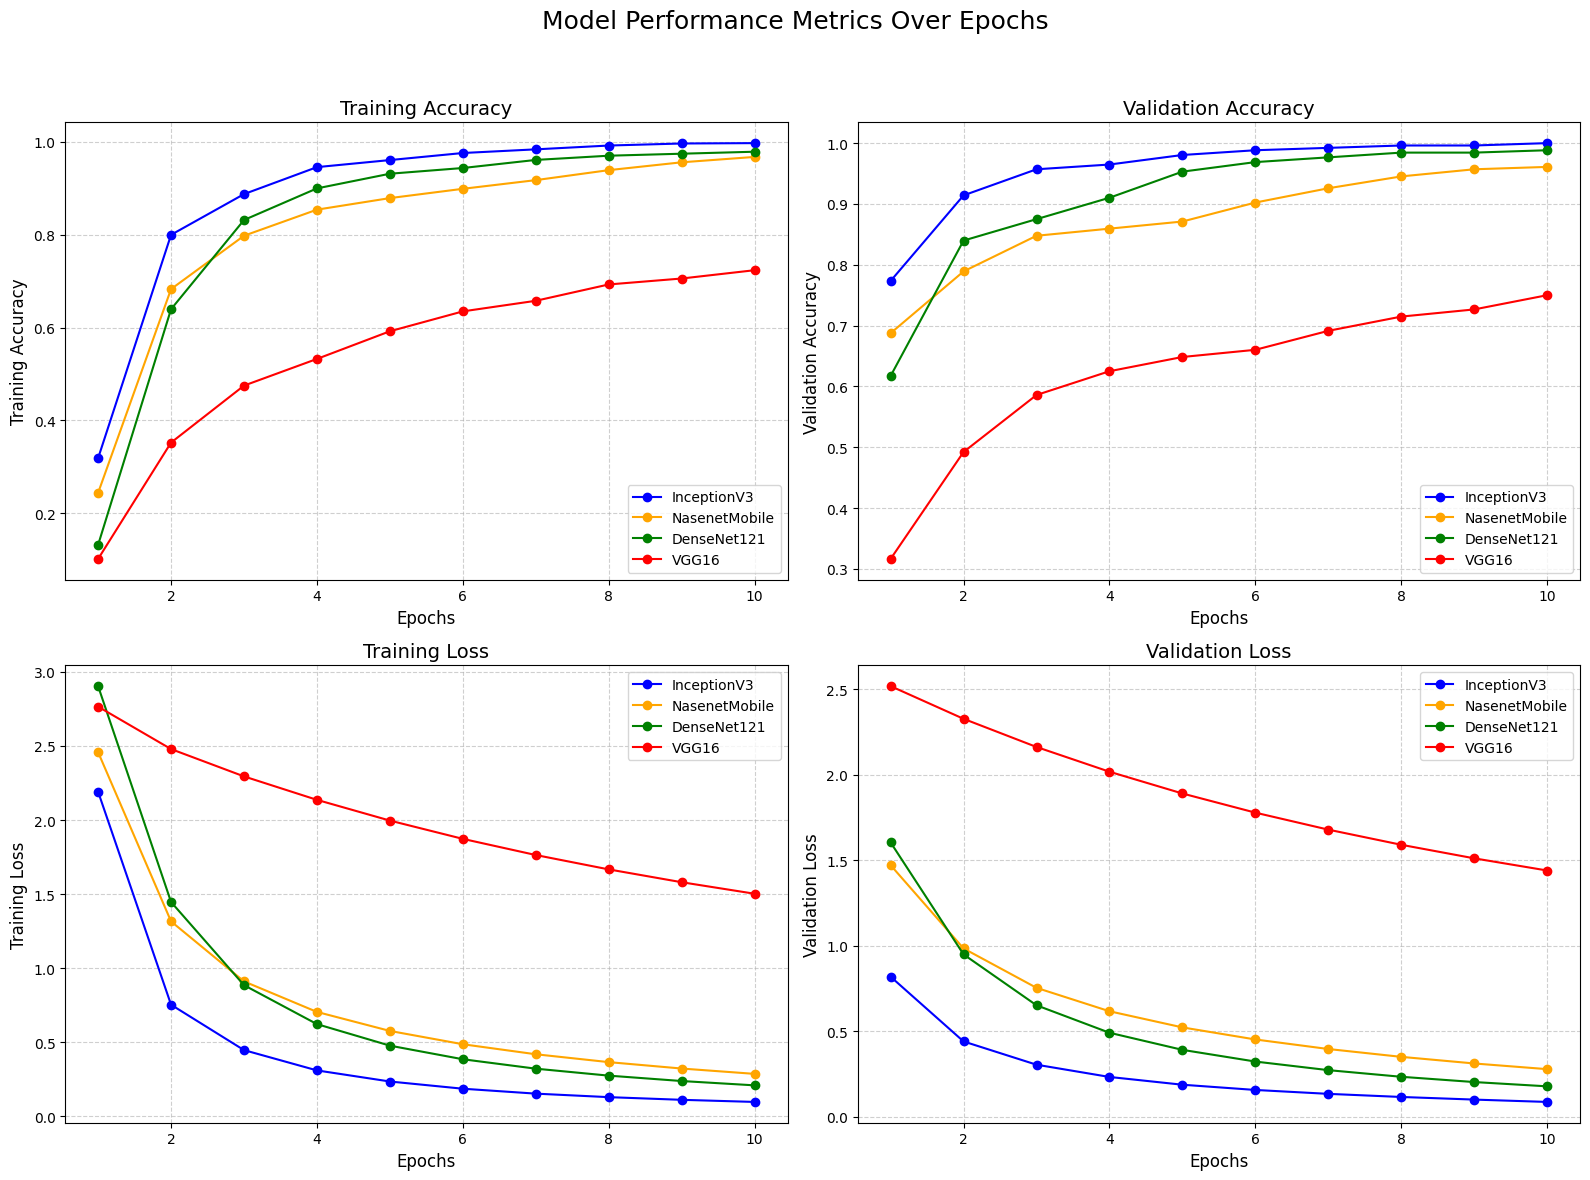

In [ ]:
import matplotlib.pyplot as plt

# Data for InceptionV3 (updated)
epochs_inception = list(range(1, 11))
train_accuracy_inception = [0.3187, 0.7998, 0.8875, 0.9456, 0.9608, 0.9760, 0.9839, 0.9921, 0.9965, 0.9973]
val_accuracy_inception = [0.7734, 0.9141, 0.9570, 0.9648, 0.9805, 0.9883, 0.9922, 0.9961, 0.9961, 1.0000]
train_loss_inception = [2.1911, 0.7533, 0.4469, 0.3099, 0.2350, 0.1863, 0.1531, 0.1294, 0.1114, 0.0971]
val_loss_inception = [0.8200, 0.4415, 0.3056, 0.2340, 0.1886, 0.1580, 0.1352, 0.1170, 0.1017, 0.0880]

# Data for NasnetMobile
epochs_nasnet = list(range(1, 11))
train_accuracy_nasnet = [0.2440, 0.6829, 0.7978, 0.8540, 0.8789, 0.8989, 0.9176, 0.9391, 0.9560, 0.9676]
val_accuracy_nasnet = [0.6875, 0.7891, 0.8477, 0.8594, 0.8711, 0.9023, 0.9258, 0.9453, 0.9570, 0.9609]
train_loss_nasnet = [2.4582, 1.3158, 0.9108, 0.7047, 0.5764, 0.4865, 0.4189, 0.3658, 0.3225, 0.2865]
val_loss_nasnet = [1.4719, 0.9852, 0.7549, 0.6180, 0.5237, 0.4531, 0.3973, 0.3515, 0.3128, 0.2796]

# Data for DenseNet121
epochs_densenet = list(range(1, 11))
train_accuracy_densenet = [0.1320, 0.6396, 0.8317, 0.8998, 0.9314, 0.9437, 0.9611, 0.9702, 0.9745, 0.9788]
val_accuracy_densenet = [0.6172, 0.8398, 0.8750, 0.9102, 0.9531, 0.9688, 0.9766, 0.9844, 0.9844, 0.9883]
train_loss_densenet = [2.9042, 1.4467, 0.8854, 0.6224, 0.4770, 0.3852, 0.3216, 0.2746, 0.2382, 0.2090]
val_loss_densenet = [1.6049, 0.9503, 0.6529, 0.4924, 0.3924, 0.3240, 0.2738, 0.2350, 0.2042, 0.1792]

# Data for VGG16
epochs_vgg = list(range(1, 11))
train_accuracy_vgg = [0.1017, 0.3523, 0.4750, 0.5325, 0.5921, 0.6349, 0.6577, 0.6929, 0.7057, 0.7236]
val_accuracy_vgg = [0.3164, 0.4922, 0.5859, 0.6250, 0.6484, 0.6602, 0.6914, 0.7148, 0.7266, 0.7500]
train_loss_vgg = [2.7656, 2.4792, 2.2947, 2.1364, 1.9964, 1.8730, 1.7639, 1.6669, 1.5803, 1.5025]
val_loss_vgg = [2.5185, 2.3274, 2.1628, 2.0181, 1.8909, 1.7789, 1.6796, 1.5911, 1.5119, 1.4407]

# Plotting all graphs
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Metrics Over Epochs', fontsize=18)

# Training Accuracy
axes[0, 0].plot(epochs_inception, train_accuracy_inception, marker='o', label='InceptionV3', color='blue')
axes[0, 0].plot(epochs_nasnet, train_accuracy_nasnet, marker='o', label='NasenetMobile', color='orange')
axes[0, 0].plot(epochs_densenet, train_accuracy_densenet, marker='o', label='DenseNet121', color='green')
axes[0, 0].plot(epochs_vgg, train_accuracy_vgg, marker='o', label='VGG16', color='red')
axes[0, 0].set_title('Training Accuracy', fontsize=14)
axes[0, 0].set_xlabel('Epochs', fontsize=12)
axes[0, 0].set_ylabel('Training Accuracy', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, linestyle='--', alpha=0.6)

# Validation Accuracy
axes[0, 1].plot(epochs_inception, val_accuracy_inception, marker='o', label='InceptionV3', color='blue')
axes[0, 1].plot(epochs_nasnet, val_accuracy_nasnet, marker='o', label='NasenetMobile', color='orange')
axes[0, 1].plot(epochs_densenet, val_accuracy_densenet, marker='o', label='DenseNet121', color='green')
axes[0, 1].plot(epochs_vgg, val_accuracy_vgg, marker='o', label='VGG16', color='red')
axes[0, 1].set_title('Validation Accuracy', fontsize=14)
axes[0, 1].set_xlabel('Epochs', fontsize=12)
axes[0, 1].set_ylabel('Validation Accuracy', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, linestyle='--', alpha=0.6)

# Training Loss
axes[1, 0].plot(epochs_inception, train_loss_inception, marker='o', label='InceptionV3', color='blue')
axes[1, 0].plot(epochs_nasnet, train_loss_nasnet, marker='o', label='NasenetMobile', color='orange')
axes[1, 0].plot(epochs_densenet, train_loss_densenet, marker='o', label='DenseNet121', color='green')
axes[1, 0].plot(epochs_vgg, train_loss_vgg, marker='o', label='VGG16', color='red')
axes[1, 0].set_title('Training Loss', fontsize=14)
axes[1, 0].set_xlabel('Epochs', fontsize=12)
axes[1, 0].set_ylabel('Training Loss', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle='--', alpha=0.6)

# Validation Loss
axes[1, 1].plot(epochs_inception, val_loss_inception, marker='o', label='InceptionV3', color='blue')
axes[1, 1].plot(epochs_nasnet, val_loss_nasnet, marker='o', label='NasenetMobile', color='orange')
axes[1, 1].plot(epochs_densenet, val_loss_densenet, marker='o', label='DenseNet121', color='green')
axes[1, 1].plot(epochs_vgg, val_loss_vgg, marker='o', label='VGG16', color='red')
axes[1, 1].set_title('Validation Loss', fontsize=14)
axes[1, 1].set_xlabel('Epochs', fontsize=12)
axes[1, 1].set_ylabel('Validation Loss', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, linestyle='--', alpha=0.6)

# Adjust layout and show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
!pip install pyngrok
!pip install streamlit
!pip install flask_ngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.2 MB/s eta 0:00:00


In [ ]:
!ngrok config add-authtoken 2s5IpQU8NpKyTdwUPswhonDqryf_3svrQ8xhDKUFL9NDFNrt5

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from flask import Flask, request, jsonify, render_template_string
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
from pyngrok import ngrok

app = Flask(__name__)

# Load the trained model
MODEL_PATH = "/content/drive/MyDrive/Models/Model_InceptionV3.h5"
model = load_model(MODEL_PATH)

# Define constants
IMAGE_RES = 224
class_names = [
    "Alovera", "Amla", "Bamboo", "Beans", "Castor", "Catharanthus",
    "Coffee", "Coriender", "Globe Amarnath", "Jackfruit", "Kasambruga",
    "Lemon", "Mango", "Marigold", "Palak"
]

# Plant uses and locations dictionary
plant_info = {
    "Alovera": {
        "characteristics": "Rich in vitamins C and E; contains antioxidants and anti-inflammatory compounds.",
        "medicinal_uses": [
            "Used topically to heal burns, cuts, and wounds.",
            "Applied for its soothing and moisturizing effects on the skin.",
            "Helps improve digestion when consumed for its detoxifying properties.",
            "Can act as a natural remedy for constipation and digestive discomfort."
        ],
        "famous_in": "Famous in tropical and subtropical regions."
    },
    "Amla": {
        "characteristics": "High in vitamin C and antioxidants; rich in fiber and polyphenols.",
        "medicinal_uses": [
            "Used to boost immunity due to its high vitamin C content.",
            "Helps in digestion and acts as a natural laxative.",
            "Used to enhance skin health and prevent aging.",
            "Commonly used to manage blood sugar levels and support heart health."
        ],
        "famous_in": "Famous in India and Southeast Asia."
    },
    "Bamboo": {
        "characteristics": "Rich in silica and minerals like magnesium and potassium.",
        "medicinal_uses": [
            "Used to improve bone health due to its high silica content.",
            "Bamboo shoots are used in traditional medicine for digestive disorders.",
            "Can be used for treating inflammation and respiratory issues.",
            "Bamboo extracts are sometimes used for detoxification and kidney health."
        ],
        "famous_in": "Famous in East Asia and Southeast Asia."
    },
    "Beans": {
        "characteristics": "High in protein, fiber, and essential vitamins like folate and iron.",
        "medicinal_uses": [
            "Used for improving heart health by lowering cholesterol levels.",
            "Helps regulate blood sugar levels and manage diabetes.",
            "Rich in fiber, which aids in digestive health and gut function.",
            "Used in folk medicine to treat inflammation and support liver health."
        ],
        "famous_in": "Famous worldwide, especially in North and South America."
    },
    "Castor": {
        "characteristics": "Contains ricinoleic acid, which has anti-inflammatory and pain-relieving properties.",
        "medicinal_uses": [
            "Castor oil is used to relieve constipation and promote bowel movement.",
            "Applied topically to reduce inflammation and joint pain.",
            "Used in hair care to promote hair growth and scalp health.",
            "Castor oil has antimicrobial properties, often used for skin infections."
        ],
        "famous_in": "Famous in tropical regions of Asia and Africa."
    },
    "Catharanthus": {
        "characteristics": "Contains alkaloids like vincristine and vinblastine, used in cancer treatment.",
        "medicinal_uses": [
            "Used in traditional medicine for managing diabetes and hypertension.",
            "The plant’s extracts are used to treat cancer, particularly leukemia and lymphoma.",
            "Improves circulation and is used for respiratory issues.",
            "Also used for skin disorders and healing wounds."
        ],
        "famous_in": "Famous in tropical and subtropical regions."
    },
    "Coffee": {
        "characteristics": "High in caffeine, antioxidants, and B-vitamins.",
        "medicinal_uses": [
            "Used to improve mental alertness and cognitive function.",
            "Acts as a natural stimulant for fatigue and mood enhancement.",
            "Rich in antioxidants, which help in reducing the risk of certain diseases.",
            "Helps in digestion and can relieve constipation."
        ],
        "famous_in": "Famous in Latin America, Southeast Asia, and Africa."
    },
    "Coriender": {
        "characteristics": "Rich in vitamins A, C, and K, and contains essential oils with antimicrobial properties.",
        "medicinal_uses": [
            "Used to improve digestion and treat indigestion.",
            "Helps lower blood sugar levels and manage diabetes.",
            "Has anti-inflammatory properties, useful for treating arthritis.",
            "Used in traditional medicine to improve skin conditions like acne."
        ],
        "famous_in": "Famous worldwide, especially in Indian and Mediterranean cuisine."
    },
    "Globe Amarnath": {
        "characteristics": "Rich in antioxidants, protein, and essential amino acids.",
        "medicinal_uses": [
            "Used for its anti-inflammatory and antioxidant properties.",
            "Helps in boosting immunity and fighting infections.",
            "Commonly used to improve digestive health and reduce bloating.",
            "Used in traditional medicine to treat skin conditions and wounds."
        ],
        "famous_in": "Famous in India and South Asia."
    },
    "Jackfruit": {
        "characteristics": "High in vitamins A and C, potassium, and dietary fiber.",
        "medicinal_uses": [
            "Used as a cooling agent in traditional medicine.",
            "Helps in digestion and aids in relieving constipation.",
            "Rich in antioxidants, it supports immune function.",
            "Used for its hydrating properties and to boost skin health."
        ],
        "famous_in": "Famous in tropical regions like Southeast Asia and India."
    },
    "Kasambruga": {
        "characteristics": "Contains alkaloids and other compounds used in traditional medicine.",
        "medicinal_uses": [
            "Used for digestive health, including as a remedy for indigestion and bloating.",
            "Promotes liver health and detoxification.",
            "Has anti-inflammatory properties, useful for treating joint pain.",
            "Used in traditional treatments for kidney health and skin infections."
        ],
        "famous_in": "Famous in Southeast Asia."
    },
    "Lemon": {
        "characteristics": "High in vitamin C, flavonoids, and citric acid.",
        "medicinal_uses": [
            "Used to boost immunity due to its high vitamin C content.",
            "Helps in detoxifying the body and improving digestion.",
            "Has antibacterial properties, useful for treating sore throats.",
            "Used in skincare for its antiseptic and skin-brightening effects."
        ],
        "famous_in": "Famous worldwide, especially in Mediterranean regions."
    },
    "Mango": {
        "characteristics": "Rich in vitamins A, C, and E; contains fiber and antioxidants.",
        "medicinal_uses": [
            "Used to support digestion and gut health due to its fiber content.",
            "Promotes skin health with its antioxidant properties.",
            "Traditionally used to treat heat-related illnesses and dehydration.",
            "Helps in boosting immunity and detoxifying the body."
        ],
        "famous_in": "Famous in tropical and subtropical regions, especially in India."
    },
    "Marigold": {
        "characteristics": "Contains lutein and zeaxanthin, which are beneficial for eye health.",
        "medicinal_uses": [
            "Used in traditional medicine to treat skin irritation and wounds.",
            "Has anti-inflammatory properties and is used for arthritis treatment.",
            "Used in eye care for its beneficial effects on vision.",
            "Applied in the form of teas or extracts to support digestion."
        ],
        "famous_in": "Famous in India, Mexico, and other parts of the world."
    },
    "Palak": {
        "characteristics": "High in vitamins A, C, and K, and rich in iron and folate.",
        "medicinal_uses": [
            "Used to treat anemia due to its high iron content.",
            "Supports digestive health and aids in constipation relief.",
            "Used to lower blood pressure due to its high potassium levels.",
            "Has anti-inflammatory properties, useful for treating pain and swelling."
        ],
        "famous_in": "Famous worldwide, particularly in India and Mediterranean countries."
    }
}
# HTML Template
html_template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Plant Image Classification</title>
    <style>
        body {
            font-family: 'Arial', sans-serif;
            background-color: #f1f7f3;
            margin: 0;
            padding: 0;
            display: flex;
            justify-content: center;
            align-items: center;
            height: 100vh;
            flex-direction: column;
        }

        h1 {
            color: #3c763d;
            font-size: 3em;
            margin-bottom: 20px;
            text-align: center;
        }
        h2 {
            color: #3c763d;
            margin-bottom: 20px;
            text-align: center;
        }
        #upload-form {
            background-color: #ffffff;
            padding: 25px;
            border-radius: 10px;
            box-shadow: 0 5px 15px rgba(0, 0, 0, 0.1);
            max-width: 500px;
            width: 100%;
            text-align: center;
        }

        input[type="file"] {
            font-size: 1.2em;
            padding: 12px;
            border: 2px solid #7bbf6a;
            border-radius: 5px;
            margin-bottom: 20px;
            width: 80%;
            box-sizing: border-box;
            background-color: #eaf5db;
            transition: border 0.3s ease;
        }

        input[type="file"]:hover {
            border-color: #4CAF50;
        }

        button {
            background-color: #4CAF50;
            color: white;
            border: none;
            padding: 12px 25px;
            font-size: 1.2em;
            border-radius: 5px;
            cursor: pointer;
            transition: background-color 0.3s;
            width: 80%;
            margin-top: 10px;
        }

        button:hover {
            background-color: #45a049;
        }

        #result {
            margin-top: 20px;
            font-size: 1.5em;
            font-weight: bold;
            color: #3c763d;
        }

        #characteristics, #uses, #famous-in, #accuracy {
            margin-top: 15px;
            font-size: 1.1em;
            color: #4d6e45;
            font-weight: normal;
        }

        .image-preview {
            max-width: 200px;
            margin-top: 20px;
            border: 3px solid #7bbf6a;
            border-radius: 8px;
            padding: 10px;
            background-color: #f3f9f3;
        }

        #preview {
            width: 100%;
            height: auto;
            border-radius: 8px;
        }

        .footer {
            margin-top: 40px;
            font-size: 0.9em;
            color: #888;
        }

        .footer a {
            color: #3c763d;
            text-decoration: none;
        }

        .footer a:hover {
            text-decoration: underline;
        }

        /* Responsive design */
        @media (max-width: 768px) {
            h1 {
                font-size: 2.5em;
            }
            h2 {
              font-size: 2em;
            }
            #upload-form {
                padding: 20px;
                width: 90%;
            }

            button {
                font-size: 1.1em;
            }
        }

        @media (max-width: 480px) {
            h1 {
                font-size: 2em;
            }
            h2 {
              font-size: 1.5em;
            }
            input[type="file"], button {
                width: 100%;
                font-size: 1em;
            }

            #result {
                font-size: 1.2em;
            }

            #characteristics, #uses, #famous-in {
                font-size: 1em;
            }
        }
    </style>
</head>
<body>
    <h1>Deep Learning based Robust Medicinal Leaves Identification</h1>
    <h2> Upload plant leaf image</h2>
    <form id="upload-form" enctype="multipart/form-data">
        <input type="file" id="image-input" accept="image/*" required>
        <button type="submit">Classify Image</button>
    </form>
    <div id="result"></div>
    <div id="accuracy"></div>
    <div id="characteristics"></div>
    <div id="uses"></div>
    <div id="famous-in"></div>
    <div class="image-preview">
        <img id="preview" src="" alt="" style="display: none;">
    </div>

    <script>
        const form = document.getElementById("upload-form");
        const imageInput = document.getElementById("image-input");
        const resultDiv = document.getElementById("result");
        const characteristicsDiv = document.getElementById("characteristics");
        const usesDiv = document.getElementById("uses");
        const famousInDiv = document.getElementById("famous-in");
        const previewImg = document.getElementById("preview");
        const accuracyDiv = document.getElementById("accuracy");
        form.addEventListener("submit", async (event) => {
            event.preventDefault();

            // Display image preview
            const file = imageInput.files[0];
            const reader = new FileReader();
            reader.onload = () => {
                previewImg.src = reader.result;
                previewImg.style.display = "block";
            };
            reader.readAsDataURL(file);

            // Prepare form data
            const formData = new FormData();
            formData.append("file", file);

            // Send request to the backend
            resultDiv.textContent = "Classifying...";
            try {
                const response = await fetch("/predict", {
                    method: "POST",
                    body: formData,
                });

                if (!response.ok) {
                    throw new Error("Failed to classify the image.");
                }

                const data = await response.json();
                resultDiv.textContent = `Predicted Class: ${data.predicted_class}`;
                characteristicsDiv.textContent = `Characteristics: ${data.characteristics}`;
                usesDiv.textContent = `Uses: ${data.uses}`;
                famousInDiv.textContent = `Famous in: ${data.famous_in}`;
                accuracyDiv.textContent = `Accuracy Score : ${(data.accuracy * 100).toFixed(2)}%`;

            } catch (error) {
                resultDiv.textContent = "Error: " + error.message;
            }
        });
    </script>
</body>
</html>

"""

@app.route("/")
def home():
    return render_template_string(html_template)

@app.route("/predict", methods=["POST"])
def predict():
    if "file" not in request.files:
        return jsonify({"error": "No file uploaded"}), 400
    file = request.files["file"]
    if file.filename == "":
        return jsonify({"error": "No file selected"}), 400
    temp_path = os.path.join("uploads", file.filename)
    os.makedirs("uploads", exist_ok=True)
    file.save(temp_path)
    input_image = load_img(temp_path, target_size=(IMAGE_RES, IMAGE_RES))
    input_image_array = img_to_array(input_image) / 255.0
    input_image_array = input_image_array[np.newaxis, ...]
    predictions = model.predict(input_image_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names[predicted_class_index]
    accuracy = np.max(predictions)

    # Get plant uses and famous location
    plant_details = plant_info.get(predicted_class_name,{"characteristics": "N/A", "uses": "N/A", "famous_in": "N/A"})

    os.remove(temp_path)
    return jsonify({
        "predicted_class": predicted_class_name,
        "characteristics": plant_details["characteristics"],
        "uses": plant_details["medicinal_uses"],
        "famous_in": plant_details["famous_in"],
        "accuracy": float(accuracy)

    })

if __name__ == "__main__":
    # Open a public URL via ngrok
    public_url = ngrok.connect(5000)
    print(f"Public URL: {public_url}")
    app.run(port=5000)


Public URL: NgrokTunnel: "https://c3e2-34-150-169-37.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [23/Feb/2025 06:08:59] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Feb/2025 06:08:59] "GET /favicon.ico HTTP/1.1" 404 -
